In [18]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import sys
sys.path.append(rootpath+'/package')
from utils.env_pca import env
from model.qagent import QAgent
from service.measurerss import measureRSS
from model.pathlossmodel import PathLossModel, NoiseMaker

In [21]:
import csv
import pickle
import numpy as np
from scipy.special import comb, perm
from itertools import combinations
from service.combinationset import combinationSet
from model.uav import UAV
import keras

In [ ]:
# div 10
# 0.2586146 0.08263365

# div 20
# 0.23592666 0.05520087

# div 30
# 0.33629215 0.120262645

# div 40
# 0.23695469 0.06928754

# div 50
# 0.2801985 0.095142916

# div 60
# 0.35521522 0.10566868

# div 70
# 0.29245633 0.077471346

# div 80
# 0.29186997 0.08496217

# div 90
# 0.28829214 0.07185271

# div 100
# 0.2922152 0.09591793

# threshold = 0.2586146+0.08263365

In [36]:
div = 100
pick = 1
threshold = 0.2922152+0.09591793
dataFolder = "/0817_PCA"

In [ ]:
# import os
# if not (os.path.isfile(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv")):
#   f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv", 'wb')
#   f.close()

In [37]:
# load vae model
from keras import backend as K
modelPath = rootpath+"/datas/trainingModelPCA/VAENoanchorModel_300sample_8UAV_8uUAV_div"+str(div)
vae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/UAVsSamples_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)


{0: {0: <model.uav.UAV object at 0x7fc0c1d37c10>, 1: <model.uav.UAV object at 0x7fc0b7021290>, 2: <model.uav.UAV object at 0x7fc0b7021a50>, 3: <model.uav.UAV object at 0x7fc0b70219d0>, 4: <model.uav.UAV object at 0x7fc0b4e91c50>, 5: <model.uav.UAV object at 0x7fc0b4e84fd0>, 6: <model.uav.UAV object at 0x7fc0b4e5aed0>, 7: <model.uav.UAV object at 0x7fc0b4f10690>, 8: <model.uav.UAV object at 0x7fc0b4f10650>, 9: <model.uav.UAV object at 0x7fc0b4f103d0>, 10: <model.uav.UAV object at 0x7fc0b4f10290>, 11: <model.uav.UAV object at 0x7fc0b4f10350>, 12: <model.uav.UAV object at 0x7fc0b4f10190>, 13: <model.uav.UAV object at 0x7fc0b4f10750>, 14: <model.uav.UAV object at 0x7fc0b4f10490>, 15: <model.uav.UAV object at 0x7fc0b4f10510>}, 1: {0: <model.uav.UAV object at 0x7fc0b4f15f10>, 1: <model.uav.UAV object at 0x7fc0b4ba8390>, 2: <model.uav.UAV object at 0x7fc0b4f01f10>, 3: <model.uav.UAV object at 0x7fc0b4f01dd0>, 4: <model.uav.UAV object at 0x7fc0b4f01b50>, 5: <model.uav.UAV object at 0x7fc0b4f01

In [38]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [39]:
groupListSamples = combinationSet(UAVsSamples)
SizeOfGroupsCombination = 0
for INumberOfCombination, GroupsOfConbination  in groupListSamples[0].items():
  for IConbination in GroupsOfConbination:
    SizeOfGroupsCombination+=1

In [40]:
_sdpResultsDatas = []
for j in range(env.N_ngps):
  with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/test_position{}_pickerror{}_deviation{}_100.csv".format(j,pick,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    _sdpResultsDatas.append(csvReader)
ShapeOfSDPResultsData = np.array(_sdpResultsDatas).shape
sdpResultsDatas = np.array(_sdpResultsDatas).reshape(env.N_ngps,ShapeOfSDPResultsData[1]//SizeOfGroupsCombination,SizeOfGroupsCombination,env.DIMENSION)
PositionOfTargetsUAVOfGroupOfSample = sdpResultsDatas.transpose((1,2,0,3))
np.array(PositionOfTargetsUAVOfGroupOfSample).shape
PositionOfTargetsUAVOfGroupOfSample = PositionOfTargetsUAVOfGroupOfSample

In [41]:
PositionOfTargetsUAVOfGroupOfSample.shape

(100, 93, 8, 2)

In [42]:
from service.combinationset import groupingFromSet
from model.sdp import calculateSDP
states = {}
currentSdpResultsDatas = {}
groupLists = combinationSet(UAVsSamples)
for iSample in UAVsSamples:
  currentSdpResultsDatas[iSample]= {}
  states[iSample] = []
  for s, groupList in groupLists[iSample].items():
    for group in groupList:
      states[iSample].append(group)
  for iState, state in enumerate(states[iSample]):
    groupOfState = groupingFromSet(state)  
    currentSdpResultsDatas[iSample][iState] = []  
    for iNumberOfGroup in groupOfState:
      if len(groupOfState[iNumberOfGroup]) > 0:
        for group in groupOfState[iNumberOfGroup]:
          if group in states[iSample]:
            indexOfGroup = states[iSample].index(group)
            currentSdpResultsDatas[iSample][iState].append(PositionOfTargetsUAVOfGroupOfSample[iSample][indexOfGroup])

In [43]:
from itertools import combinations
allEstimateGroups = {}
states = {}
for iSample in UAVsSamples:
  allEstimateGroups[iSample] = {}
  UAVsSample = UAVsSamples[iSample]
  groupListSample = combinationSet({0:UAVsSample})[0]

  states[iSample] = []
  for s, groupList in groupListSample.items():
    for group in groupList:
      states[iSample].append(group)

  for iState, state in enumerate(states[iSample]):
    # print(len(state),len(state)-(env.DIMENSION+1))
    for kickNumber in range(len(state)-(3+1)):
      # print(kickNumber)
      for ikick in range(kickNumber+1):
        estimateGroups = list(combinations(state,len(state)-ikick))
        allEstimateGroups[iSample][iState] = estimateGroups
print(len(allEstimateGroups[0]))

93


In [44]:
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)), axis=1)

In [ ]:
# sdpOfSubGroupOfState= {} # state > index in estimateGroup > sdp
# for iSample in UAVsSamples:
#   sdpOfSubGroupOfState[iSample]= {}
#   pathLossModel = PathLossModel()
#   for iEstimateGroups in allEstimateGroups[iSample]:
#     sdpOfSubGroup = {}
#     sdpResultsDatas = None
#     rawDatas = []
#     ReadSampleSize = 1
#     estimateGroups = list(map(list, allEstimateGroups[iSample][iEstimateGroups]))
#     groupSize = np.array(estimateGroups).shape[0]
#     for iEstimateGroup, estimateGroup in enumerate(estimateGroups):
#       stateIndex = states[iSample].index(estimateGroup)
#       sdpOfSubGroup[iEstimateGroup] = currentSdpResultsDatas[iSample][stateIndex]
#     sdpOfSubGroupOfState[iSample][iEstimateGroups] = sdpOfSubGroup

In [ ]:
# vaeOutputs = {}
# normalizeVAETestingDatas = {}
# for iSample in UAVsSamples:
#   print("iSample",iSample)
#   vaeOutputs[iSample] = []
#   normalizeVAETestingDatas[iSample] = []
#   for iState in allEstimateGroups[iSample]:
#     estimateGroups = []    
#     for iEstimateGroup, estimateGroup in enumerate(allEstimateGroups[iSample][iState]):
#       estimateGroups.append(estimateGroup)
#     dualGroupingTestingData = []
#     for groupOfI in estimateGroups:
#       for groupOfJ in estimateGroups:
#         indexOfSubGroupInStateOfI = allEstimateGroups[iSample][iState].index(groupOfI)
#         indexOfSubGroupInStateOfJ = allEstimateGroups[iSample][iState].index(groupOfJ)
#         firstTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfI]).copy().tolist()
#         secondTrainingPickGroupData = np.array(sdpOfSubGroupOfState[iSample][iState][indexOfSubGroupInStateOfJ]).copy().tolist()
#         # list (map(lambda i: firstTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
#         # list (map(lambda i: secondTrainingPickGroupData.append(np.array(anchors[iSample][i].observedPosition).reshape(1,3)), range(env.N_gps)))
#         dualGroupingTestingData.append([firstTrainingPickGroupData, secondTrainingPickGroupData])
#     dualGroupingTestingData = np.array(dualGroupingTestingData).astype('float32')  
#     VAETestingData = dualGroupingTestingData.reshape(len(dualGroupingTestingData), np.prod(dualGroupingTestingData.shape[1:]))
#     # VAETestingData = dualGroupingTestingData.reshape((dualGroupingTestingData.shape[0],
#     #       dualGroupingTestingData.shape[3],
#     #       dualGroupingTestingData.shape[1],
#     #       dualGroupingTestingData.shape[4],
#     #       dualGroupingTestingData.shape[2]))   
#     data_min = 0
#     data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
#     normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
#     normalizeVAETestingData = normalizeVAETestingData.astype('float32')
#     # print(np.array(normalizeVAETestingData).shape)
#     vaeOutput = vae.predict(normalizeVAETestingData, batch_size = 2048*4)
#     vaeOutputs[iSample].append(vaeOutput)
#     normalizeVAETestingDatas[iSample].append(normalizeVAETestingData)



In [ ]:
# f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "wb")
# pickle.dump(vaeOutputs, f)
# f.close()

# f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "wb")
# pickle.dump(normalizeVAETestingDatas, f)
# f.close()

In [45]:
f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_vaeOutputs_pick{}_div{}.pkl".format(pick,div), "rb")
vaeOutputs = pickle.load(f)
f.close()
f = open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/VAE_normalizeVAETestingDatas_pick{}_div{}.pkl".format(pick,div), "rb")
normalizeVAETestingDatas = pickle.load(f)
f.close()

In [46]:
optimalMSE = {}
optimalMSEGroup = {}
def runVAEOutput(iSample):
  print("iSample",iSample)
  _optimalMSE = []
  _optimalMSEGroup = []
  UAVsSample = UAVsSamples[iSample]
  
  for iState in allEstimateGroups[iSample]:
    try:
      mse = MSE(vaeOutputs[iSample][iState], normalizeVAETestingDatas[iSample][iState])
      # if iState %10 == 0:
        # print("iState:",iSample,iState)
      _optimalMSE.append(mse)
      _optimalMSEGroup.append(states[iSample][iState])
    except:
      continue    
  optimalMSE[iSample] = _optimalMSE
  optimalMSEGroup[iSample] = _optimalMSEGroup
  print("finish")
for iSample in UAVsSamples:
  runVAEOutput(iSample)

iSample 0
finish
iSample 1
finish
iSample 2
finish
iSample 3
finish
iSample 4
finish
iSample 5
finish
iSample 6
finish
iSample 7
finish
iSample 8
finish
iSample 9
finish
iSample 10
finish
iSample 11
finish
iSample 12
finish
iSample 13
finish
iSample 14
finish
iSample 15
finish
iSample 16
finish
iSample 17
finish
iSample 18
finish
iSample 19
finish
iSample 20
finish
iSample 21
finish
iSample 22
finish
iSample 23
finish
iSample 24
finish
iSample 25
finish
iSample 26
finish
iSample 27
finish
iSample 28
finish
iSample 29
finish
iSample 30
finish
iSample 31
finish
iSample 32
finish
iSample 33
finish
iSample 34
finish
iSample 35
finish
iSample 36
finish
iSample 37
finish
iSample 38
finish
iSample 39
finish
iSample 40
finish
iSample 41
finish
iSample 42
finish
iSample 43
finish
iSample 44
finish
iSample 45
finish
iSample 46
finish
iSample 47
finish
iSample 48
finish
iSample 49
finish
iSample 50
finish
iSample 51
finish
iSample 52
finish
iSample 53
finish
iSample 54
finish
iSample 55
finish
iS

In [47]:
import pickle as dill
anomalyUAVs = []
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/anomalyUAVs_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    try:
      anomalyUAVs.append(dill.load(f))
    except EOFError:
      break
print(anomalyUAVs)

[[9], [11], [15], [8], [10], [10], [13], [14], [15], [12], [12], [0], [4], [11], [7], [9], [0], [0], [5], [4], [15], [7], [12], [11], [9], [3], [9], [2], [0], [8], [12], [13], [3], [6], [15], [2], [9], [4], [6], [4], [3], [12], [11], [4], [15], [14], [5], [3], [14], [5], [4], [0], [7], [8], [9], [6], [10], [9], [1], [8], [1], [15], [10], [2], [15], [9], [6], [11], [0], [1], [0], [11], [11], [13], [12], [3], [12], [2], [15], [7], [6], [15], [10], [9], [14], [15], [4], [7], [1], [9], [11], [4], [9], [13], [4], [0], [8], [5], [7], [4]]


In [ ]:
# div 10
# 0.2586146 0.08263365

# div 20
# 0.23592666 0.05520087

# div 30
# 0.33629215 0.120262645

# div 40
# 0.23695469 0.06928754

# div 50
# 0.2801985 0.095142916

# div 60
# 0.35521522 0.10566868

# div 70
# 0.29245633 0.077471346

# div 80
# 0.29186997 0.08496217

# div 90
# 0.28829214 0.07185271

# div 100
# 0.2922152 0.09591793

# threshold = 0.2922152+0.09591793

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax1 = plt.subplots(1,1, figsize = (12,12))
# aggregateMSE = {}
# for iSample in UAVsSamples:
#   aggregateMSE[iSample] ={}  
#   sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
#   sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
#   for i in sortIndex[-3:]:
#     print("optimalGroup ",i,":",optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
#   aggregateMSE[iSample] = []
#   for i in range(len(optimalMSE[iSample])):
#     aggregateMSE[iSample].append(np.mean(optimalMSE[iSample][i]))
#   index = np.argmin(aggregateMSE[iSample])
#   print("optimalGroup",optimalMSEGroup[iSample][index])
#   # print("anomalyUAVs",anomalyUAVs[iSample])
#   ax1.plot(sortOptionalMSE[-50:])
#   ax1.axhline(y = threshold, color = 'r', linestyle = '-')
#   plt.grid()


In [ ]:
optimalMSE[0]

[array([0.6728246], dtype=float32),
 array([0.67252827], dtype=float32),
 array([0.6689384], dtype=float32),
 array([0.679967], dtype=float32),
 array([0.6749078], dtype=float32),
 array([0.67301035], dtype=float32),
 array([0.68145233], dtype=float32),
 array([0.67275393], dtype=float32),
 array([0.68156254], dtype=float32),
 array([0.68017924], dtype=float32),
 array([0.27792913], dtype=float32),
 array([0.4145347], dtype=float32),
 array([0.28919014], dtype=float32),
 array([0.41630048], dtype=float32),
 array([0.29195306], dtype=float32),
 array([0.28058743], dtype=float32),
 array([0.2780689], dtype=float32),
 array([0.29834157], dtype=float32),
 array([0.28900617], dtype=float32),
 array([0.291935], dtype=float32),
 array([0.5746031], dtype=float32),
 array([0.56891227], dtype=float32),
 array([0.5832046], dtype=float32),
 array([0.56902134], dtype=float32),
 array([0.5839046], dtype=float32),
 array([0.5785509], dtype=float32),
 array([0.59070206], dtype=float32),
 array([0.6020

1
20.220721690355678 24.019278309644324
[29 29 19  7 29 26 27 26 29 16 17 19 29 29 27 21 12 22 13 29 25 12 17 29
 29 24 42 16  7 30 26 29 29 29 29 29  6 58 29 13 25 11 15 30 29  4  8 29
 24 19 29 28 13 29 29 29 10 29 29 20 36 29 33 29 18 29 18 25  7 36 27 29
 29 12 29 29 11 11 29  9 14  5 12 29 20 23 29  5 29 26 16  8 29  8  7 10
 14 16  7 28]
100
46


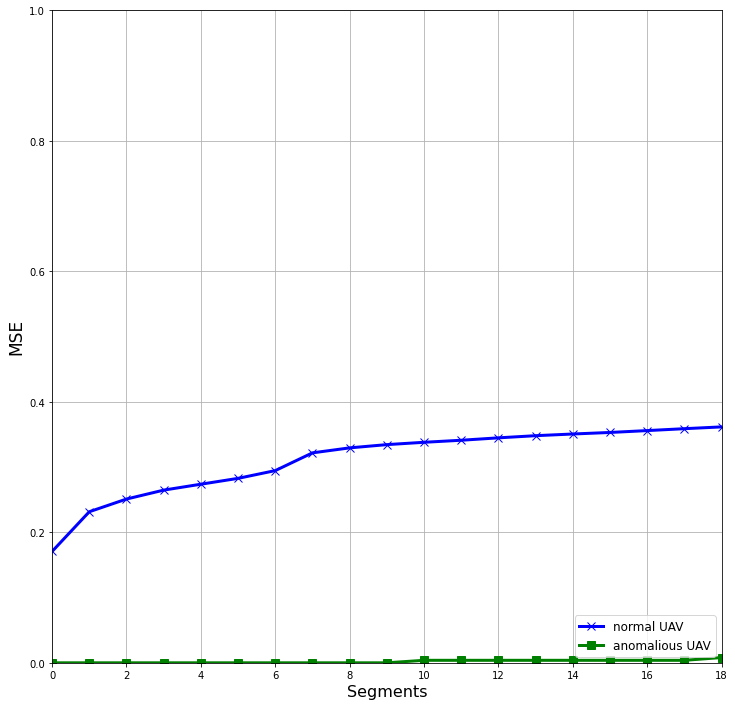

In [48]:
import matplotlib.pyplot as plt
# threshold = 0.32+0.07
print(pick)
fig, ax1 = plt.subplots(1,1, figsize = (12,12))
sumY = np.zeros(len(optimalMSE[0]))
sumAnomalyY = np.zeros(len(optimalMSE[0]))
sumthreaholdIndex = []
thresholdSampleSize = 100
for iSample in UAVsSamples:
  if not iSample < thresholdSampleSize:
    break
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
  PDFWindowsMemberTable = {}
  anomalyId = []
  threaholdIndex = 0
  for iUAV,uav in UAVsSamples[iSample].items():
    if uav.observedPosition != None:
      PDFWindowsMemberTable[uav.id] = []
      if uav.observedPosition != uav.realPosition:
        anomalyId.append(uav.id)
        # print(uav.id,uav.observedPosition,uav.realPosition,np.linalg.norm(np.array(uav.observedPosition)-np.array(uav.realPosition)))
  for i in range(0,len(sortIndex)):
    if sortOptionalMSE[i] > threshold:
      threaholdIndex = i
      sumthreaholdIndex.append(i)
      break
  # print(WindowsMemberTable)
  for iWindows in range(0,len(sortIndex)):
    memberTable = {}
    for groupMember in optimalMSEGroup[iSample][sortIndex[iWindows]]:
      try:
        memberTable[groupMember] += sortOptionalMSE[iWindows]
      except:
        memberTable[groupMember] = sortOptionalMSE[iWindows]
    for UAVId in PDFWindowsMemberTable:
      isHaveValue = False
      for member, value in memberTable.items():
        if member == UAVId:
          PDFWindowsMemberTable[UAVId].append(value)
          isHaveValue = True
      if not isHaveValue:
        if len(PDFWindowsMemberTable[UAVId]) > 0:
          PDFWindowsMemberTable[UAVId].append(PDFWindowsMemberTable[UAVId][-1])
        else:
          PDFWindowsMemberTable[UAVId].append(0)
  _sumY = np.zeros(len(optimalMSE[iSample]))
  _sumAnomalyY = np.zeros(len(optimalMSE[iSample]))
  for UAVId in PDFWindowsMemberTable:
    # print(UAVId, PDFWindowsMemberTable[UAVId])
    from scipy.interpolate import make_interp_spline
    x = np.arange(0,len(PDFWindowsMemberTable[UAVId]))
    y = PDFWindowsMemberTable[UAVId]
    # model=make_interp_spline(x,y)
    # xs=np.linspace(1,15,5000)
    # ys=model(xs)
    lineColor = 'b'
    if UAVId in anomalyId:
      lineColor = 'g'
    # ax1.plot(x,y,linestyle='-', c=lineColor, alpha=1/(1*thresholdSampleSize))
    if UAVId in anomalyId:
      for iyv, _xv in enumerate(y):
        _sumAnomalyY[iyv] += _xv
    else:
      for iyv, _yv in enumerate(y):
        _sumY[iyv] += _yv
  # print(_sumY)
  sumY += _sumY/(env.N_gps - len(anomalyId))
  sumAnomalyY += _sumAnomalyY/(len(anomalyId))
    # ax1.legend()
  # ax1.plot( np.arange(0,len(sortOptionalMSE)),sortOptionalMSE[::-1])
  # ax1.axvline(x=threaholdIndex,linestyle='-', c='r', alpha=1/(2*thresholdSampleSize))
  # ax1.legend()
meanY = sumY/(thresholdSampleSize)
meanAnomalyY = sumAnomalyY/(thresholdSampleSize)
import numpy as np, scipy.stats as st
lower,upper = st.t.interval(0.95, len(sumthreaholdIndex)-1, loc=np.mean(sumthreaholdIndex), scale=st.sem(sumthreaholdIndex))
print(lower,upper)
ax1.plot(x,meanY, label= "normal UAV",linestyle='-', c='b', linewidth=3, marker = 'x', markersize=8)
ax1.plot(x,meanAnomalyY, label= "anomalious UAV",linestyle='-', c='g', linewidth=3, marker = 's', markersize=8)
sumthreaholdIndex = np.array(sumthreaholdIndex)
print(sumthreaholdIndex)
# sumthreaholdIndex = np.array(sumthreaholdIndex)[sumthreaholdIndex >lower]
print(len(sumthreaholdIndex))
sumthreaholdIndex = sumthreaholdIndex[sumthreaholdIndex < upper]
print(len(sumthreaholdIndex))
# ax1.axvline(x=np.mean(sumthreaholdIndex), label= "cutting", c='r', linewidth=3)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('Segments', fontsize=16)
ax1.set_ylabel('MSE', fontsize=17)
# ax1.set_title('{} div {} pick {}'.format(dataFolder.split("_")[1], div, pick))
ax1.set_ylim([0,1])
ax1.set_xlim([0,18])
plt.grid()

# plt.savefig(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/appearance{}_{}".format(div,pick))
# plt.savefig(rootpath+"/datas/anomalyNewSDPResult/appearancePCA{}_{}".format(div,pick))

In [49]:
avgY = list (map(lambda x: np.around(x, 3), meanY))
avgAnomalyY = list (map(lambda x: np.around(x, 3), meanAnomalyY))
print(avgY)
print(avgAnomalyY)

[0.171, 0.232, 0.251, 0.265, 0.274, 0.283, 0.295, 0.322, 0.329, 0.334, 0.338, 0.341, 0.345, 0.348, 0.351, 0.353, 0.356, 0.359, 0.362, 0.365, 0.368, 0.371, 0.374, 0.378, 0.382, 0.386, 0.39, 0.394, 0.4, 0.484, 0.5, 0.51, 0.515, 0.52, 0.524, 0.528, 0.531, 0.535, 0.538, 0.54, 0.543, 0.545, 0.547, 0.551, 0.553, 0.555, 0.557, 0.559, 0.562, 0.564, 0.565, 0.567, 0.569, 0.571, 0.573, 0.575, 0.577, 0.579, 0.582, 0.584, 0.586, 0.589, 0.591, 0.593, 0.595, 0.597, 0.599, 0.601, 0.603, 0.605, 0.607, 0.609, 0.611, 0.616, 0.619, 0.621, 0.623, 0.626, 0.629, 0.632, 0.634, 0.637, 0.64, 0.644, 0.647, 0.65, 0.654, 0.659, 0.664, 0.669, 0.675, 0.684, 0.7]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.008, 0.008, 0.016, 0.017, 0.025, 0.029, 0.037, 0.037, 0.046, 0.055, 0.065, 0.494, 0.506, 0.514, 0.518, 0.523, 0.526, 0.529, 0.532, 0.537, 0.54, 0.542, 0.544, 0.546, 0.548, 0.552, 0.555, 0.556, 0.558, 0.56, 0.563, 0.565, 0.567, 0.568, 0.57, 0.572, 0.57

In [ ]:
# import matplotlib.pyplot as plt
# # threshold = 0.32+0.07
# print(pick)
# sumY = np.zeros(len(optimalMSE[0])-windowsSize)
# sumAnomalyY = np.zeros(len(optimalMSE[0])-windowsSize)
# for iSample in UAVsSamples:
#   if not iSample < thresholdSampleSize:
#     break
#   sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=False)
#   sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]
#   ListOfMSEWindowsMemberTable = {}
#   anomalyId = []
#   for iUAV,uav in UAVsSamples[iSample].items():
#     if uav.observedPosition != None:
#       ListOfMSEWindowsMemberTable[uav.id] = []
#       if uav.observedPosition != uav.realPosition:
#         anomalyId.append(uav.id)
#   print(anomalyId)
#   # print(WindowsMemberTable)
#   for iWindow in range(0,len(sortIndex)):
#     memberTable = {}
#     i = sortIndex[iWindow]
#     for groupMember in optimalMSEGroup[iSample][i]:
#       memberTable[groupMember] = np.mean(optimalMSE[iSample][i])
#     # print(memberTable)
#     for UAVId in ListOfMSEWindowsMemberTable:
#       for member, value in memberTable.items():
#         if member == UAVId:
#           ListOfMSEWindowsMemberTable[UAVId].append(value)
#   # print(ListOfMSEWindowsMemberTable)
#   import pandas as pd
#   import matplotlib.pyplot as plt
#   anomalysMSEs = []
#   normalMSEs = []
#   for uavId, MSEs in ListOfMSEWindowsMemberTable.items():
#     if uavId in anomalyId:
#       anomalysMSEs.extend(MSEs)
#     else:
#       normalMSEs.extend(MSEs)
#   df1 = pd.DataFrame(anomalysMSEs,columns=['anomalys'])
#   df2 = pd.DataFrame(normalMSEs,columns=['normal'])
#   df = pd.concat([df1,df2], axis=1)
#   print(df)
#   df.plot.box(title="Box Chart",showfliers=False)
#   plt.grid(linestyle="--", alpha=0.3)
#   plt.show()
#   break

In [ ]:
# threshold = 0.32+0.07
memberTableSample = {}
for iSample in UAVsSamples:
  sortIndex = sorted(range(len(optimalMSE[iSample])), key=lambda k: np.mean(optimalMSE[iSample][k]), reverse=True)
  sortOptionalMSE = [np.mean(optimalMSE[iSample][i]) for i in sortIndex]

  memberTable = {}
  for i in sortIndex:
    if np.mean(optimalMSE[iSample][i]) < threshold:
      print(optimalMSEGroup[iSample][i],np.mean(optimalMSE[iSample][i]),np.std(optimalMSE[iSample][i]))
      for groupMember in optimalMSEGroup[iSample][i]:
        try:
          memberTable[groupMember] += 1
        except:
          memberTable[groupMember] = 1
  memberTableSample[iSample] = memberTable
  print(len(memberTableSample[iSample]))
# print(memberTableSample)

memberIdSample = {}
memberAmountSample = {}
for iSample, memberTableOfSample in memberTableSample.items():
  memberId = []
  memberAmount = []
  for iMember, amount in memberTableOfSample.items():
    memberId.append(iMember)
    memberAmount.append(amount)
  memberIdSample[iSample] = memberId
  memberAmountSample[iSample] = memberAmount

[0, 3, 4, 12, 15] 0.32120323 0.0
[0, 3, 4, 8, 12, 15] 0.3127435 0.03973786
[0, 4, 8, 12, 15] 0.23963645 0.0
6
[1, 7, 11, 14, 15] 0.22049867 0.0
5
[2, 4, 7, 8, 11, 14] 0.30800945 0.07022367
[4, 7, 8, 11, 14] 0.19968036 0.0
[2, 4, 7, 11, 14] 0.10427557 0.0
6
[0, 3, 4, 10, 11] 0.2580551 0.0
[0, 3, 8, 10, 11] 0.2537747 0.0
[3, 4, 8, 10, 11] 0.23268376 0.0
[0, 3, 4, 8, 10, 11] 0.21596844 0.07343191
[0, 4, 8, 10, 11] 0.1805651 0.0
[0, 3, 4, 8, 11] 0.13766178 0.0
[0, 3, 4, 8, 10] 0.13731204 0.0
6
[1, 2, 8, 9, 10] 0.3199461 0.0
[1, 2, 9, 10, 11] 0.2865425 0.0
[1, 8, 9, 10, 11] 0.23579502 0.0
6
0
[0, 2, 3, 9, 10] 0.30249178 0.0
5
0
[1, 2, 7, 8, 12, 15] 0.31791815 0.030303758
[1, 7, 8, 12, 15] 0.30816427 0.0
[2, 7, 8, 12, 15] 0.2999677 0.0
6
[1, 6, 7, 8, 15] 0.30953413 0.0
5
0
[1, 3, 4, 9, 11] 0.3122467 0.0
[1, 3, 4, 9, 12] 0.29697448 0.0
6
[8, 10, 12, 14, 15] 0.2838699 0.0
5
[3, 4, 7, 9, 11, 15] 0.3149806 0.07174024
[4, 7, 9, 11, 15] 0.3116221 0.0
[3, 7, 9, 11, 15] 0.31094646 0.0
[3, 4, 7, 11, 

In [ ]:
goodUAVsSample = {}
for iSample in UAVsSamples:
  trainSum = np.sum(memberAmountSample[iSample])
  confidenceSum = trainSum*0.9//1
  # print(trainSum, confidenceSum,memberAmountSample)
  candidateUAV = []
  sortMap = sorted(memberTableSample[iSample].items(), key=lambda x:x[1], reverse=True)
  # print(iSample,sortMap)
  for i, v in sortMap:
    for _ in range(v):
      candidateUAV.append(i)
  # print(candidateUAV) 
  goodUAVID = []
  for i, v in enumerate(candidateUAV):
    if i <= confidenceSum:
      if v in goodUAVID:
        continue
      else:
        goodUAVID.append(v)
  # print(goodUAVID)
  goodUAVsSample[iSample] = goodUAVID
  # break
# print(goodUAVsSample)

In [ ]:
import pickle as dill
_anomalyUAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/UAVsSamples_pick{}div{}_100.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _anomalyUAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
anomalyUAVsSamples = _anomalyUAVsSamples
print(_anomalyUAVsSamples)

{0: {0: <model.uav.UAV object at 0x7fde67c30190>, 1: <model.uav.UAV object at 0x7fde67d9e3d0>, 2: <model.uav.UAV object at 0x7fde67d9e0d0>, 3: <model.uav.UAV object at 0x7fde67d9eb90>, 4: <model.uav.UAV object at 0x7fde67d9eb10>, 5: <model.uav.UAV object at 0x7fde67d9ea90>, 6: <model.uav.UAV object at 0x7fde67d9ebd0>, 7: <model.uav.UAV object at 0x7fde67d9e950>, 8: <model.uav.UAV object at 0x7fde67d9ea10>, 9: <model.uav.UAV object at 0x7fde67d9e490>, 10: <model.uav.UAV object at 0x7fde67d9e990>, 11: <model.uav.UAV object at 0x7fde67d9e510>, 12: <model.uav.UAV object at 0x7fde67d9e550>, 13: <model.uav.UAV object at 0x7fde67d9e8d0>, 14: <model.uav.UAV object at 0x7fde67d9e1d0>, 15: <model.uav.UAV object at 0x7fde67d9e350>}, 1: {0: <model.uav.UAV object at 0x7fde67d9eb50>, 1: <model.uav.UAV object at 0x7fde67d9e590>, 2: <model.uav.UAV object at 0x7fde65090f50>, 3: <model.uav.UAV object at 0x7fde650907d0>, 4: <model.uav.UAV object at 0x7fde67d5f650>, 5: <model.uav.UAV object at 0x7fde67d5f

In [ ]:
TP = 0
for iSample in goodUAVsSample:
  # print(anomalyUAVs[iSample],goodUAVsSample[iSample])
  for anomlayUAV in anomalyUAVs[iSample]:
    if not anomlayUAV in goodUAVsSample[iSample] and len(goodUAVsSample[iSample]) != 0:
      TP+= 1.0

TN = 0
for iSample in goodUAVsSample:
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(iSample,uav.id,uav.observedPosition,uav.realPosition,uav.id,goodKLUAVsSample[iSample])
      if uav.id in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None :
          TN += 1.0

FN = 0
for iSample in goodUAVsSample:
   for anomlayUAV in anomalyUAVs[iSample] :
      if anomlayUAV in goodUAVsSample[iSample] or len(goodUAVsSample[iSample]) == 0:
        FN += 1.0

FP = 0
for iSample in goodUAVsSample:
  #  for _, uav in UAVsSamples[iSample].items():
      # print(iSample,uav.id,goodUAVsSample[iSample],uav.observedPosition,uav.realPosition)
      # break
   for _, uav in anomalyUAVsSamples[iSample].items():
      # print(iSample,uav.id,uav.observedPosition,uav.realPosition,uav.id,goodKLUAVsSample[iSample][0])
      if uav.id not in goodUAVsSample[iSample] and uav.observedPosition == uav.realPosition and uav.observedPosition != None :
        # print("====",iSample,uav.id,goodUAVsSample[iSample],anomalyUAVs[iSample],uav.observedPosition,uav.realPosition)
        FP += 1.0
print("TP:",(TP/len(goodUAVsSample)) *100)
print("TN:",(TN/len(goodUAVsSample))*100)
print("FP:",(FP/len(goodUAVsSample)) *100)
print("FN:",(FN/len(goodUAVsSample))*100)
try:
  print("Precision:",(TP/(FP+TP))*100)
except:
  print("Precision: 0")
try:
  print("Recall:",(TP/(FN+TP))*100)
except:
  print("Recall: 0")
print("")
# f = open(rootpath+"/datas/datas_forAnomalyDetection/BestAnchorsPCA/100sample_{}anomaly_{}div_SelectedAnchors_VAE.pkl".format(pick,div), "wb")
# pickle.dump(goodUAVsSample, f)
# f.close()


TP: 170.0
TN: 480.99999999999994
FP: 119.0
FN: 30.0
Precision: 58.82352941176471
Recall: 85.0



In [ ]:
# import csv

# with open(rootpath+"/datas/anomalyNewSDPResult"+dataFolder+"/result.csv", 'a', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["Deviation_pick", "TP", "TN", "FP", "FN"])
#     writer.writerow(["{}_{}".format(div, pick), (TP/len(goodUAVsSample)) *100, (TN/len(goodUAVsSample))*100, (FP/len(goodUAVsSample)) *100, (FN/len(goodUAVsSample))*100])

In [ ]:
# 0.2586146 0.08263365
# div 10 pick 1
TP: 95.0
TN: 697.0
FP: 8.0
FN: 0.0
Precision: 96.9387755
Recall: 95.0

# div 10 pick 2
TP: 186.0
TN: 579.0
FP: 21.0
FN: 14.000000000000002
Precision: 89.85507246376811
Recall: 93.0

# div 10 pick 3
TP: 247.00000000000003
TN: 438.99999999999994
FP: 61.0
FN: 53.0
Precision: 80.1948051948052
Recall: 82.33333333333334

# ======================

# 0.2922152 0.09591793
# div 20 pick 1
TP: 100.0
TN: 689.0
FP: 11.0
FN: 0.0
Precision: 90.09009009009009
Recall: 100.0

# div 20 pick 2
TP: 193.0
TN: 592.0
FP: 8.0
FN: 7.000000000000001
Precision: 96.01990049751244
Recall: 96.5

# div 20 pick 3
TP: 229.0
TN: 409.0
FP: 91.0
FN: 71.0
Precision: 71.5625
Recall: 76.33333333333333

# ======================

# 0.2922152 0.09591793
# div 30 pick 1
TP: 94.0
TN: 689.0
FP: 11.0
FN: 6.0
Precision: 89.52380952380953
Recall: 94.0

# div 30 pick 2
TP: 175.0
TN: 570.0
FP: 30.0
FN: 25.0
Precision: 85.36585365853658
Recall: 87.5

# div 30 pick 3
TP: 212.0
TN: 394.0
FP: 106.0
FN: 88.0
Precision: 66.66666666666666
Recall: 70.66666666666667

# ======================

# 0.29186997 0.08496217
# div 40 pick 1
TP: 98.0
TN: 643.0
FP: 56.99999999999999
FN: 2.0
Precision: 63.2258064516129
Recall: 98.0

# 0.29186997 0.12496217
# div 40 pick 2
TP: 184.0
TN: 543.0
FP: 56.99999999999999
FN: 16.0
Precision: 76.34854771784232
Recall: 92.0

# 0.32629215 0.120262645
# div 40 pick 3
TP: 213.0
TN: 379.0
FP: 121.0
FN: 87.0
Precision: 63.772455089820355
Recall: 71.0

# ======================

# 0.23592666 0.05520087
# div 50 pick 1
TP: 97.0
TN: 644.0
FP: 56.00000000000001
FN: 3.0
Precision: 63.39869281045751
Recall: 97.0

# div 50 pick 2
TP: 183.0
TN: 540.0
FP: 60.0
FN: 17.0
Precision: 75.30864197530865
Recall: 91.5

# div 50 pick 3
TP: 191.0
TN: 338.0
FP: 162.0
FN: 109.00000000000001
Precision: 54.107648725212464
Recall: 63.66666666666667

# ======================

# 0.23592666 0.05520087
# div 60 pick 1
TP: 96.0
TN: 642.0
FP: 57.99999999999999
FN: 4.0
Precision: 62.33766233766234
Recall: 96.0

# div 60 pick 2
TP: 170.0
TN: 503.0
FP: 97.0
FN: 30.0
Precision: 63.670411985018724
Recall: 85.0

# div 60 pick 3
TP: 200.99999999999997
TN: 345.0
FP: 155.0
FN: 99.0
Precision: 56.46067415730337
Recall: 67.0

# ======================

# 0.28829214 0.07185271
# div 70 pick 1
TP: 95.0
TN: 642.0
FP: 57.99999999999999
FN: 5.0
Precision: 62.091503267973856
Recall: 95.0

# 0.25795469 0.06928754
# div 70 pick 2
TP: 170.0
TN: 480.99999999999994
FP: 119.0
FN: 30.0
Precision: 58.82352941176471
Recall: 85.0

# 0.28829214 0.07185271
# div 70 pick 3
TP: 193.0
TN: 331.0
FP: 169.0
FN: 107.0
Precision: 53.31491712707182
Recall: 64.33333333333333

# ======================

# 0.2701985 0.095142916
# div 80 pick 1
TP: 99.0
TN: 644.0
FP: 56.00000000000001
FN: 1.0
Precision: 63.87096774193548
Recall: 99.0

# 0.2586146 0.08263365
# div 80 pick 2
TP: 171.0
TN: 483.0
FP: 117.0
FN: 28.999999999999996
Precision: 59.375
Recall: 85.5

# 0.2701985 0.095142916
# div 80 pick 3
TP: 168.0
TN: 285.0
FP: 215.0
FN: 132.0
Precision: 43.86422976501306
Recall: 56.00000000000001

# ======================

# 0.22492666 0.05520087
# div 90 pick 1
TP: 96.0
TN: 651.0
FP: 49.0
FN: 4.0
Precision: 66.20689655172414
Recall: 96.0

# 0.22592666 0.05520087
# div 90 pick 2
TP: 166.0
TN: 496.0
FP: 104.0
FN: 34.0
Precision: 61.48148148148148
Recall: 83.0

# 0.23592666 0.05520087
# div 90 pick 3
TP: 173.0
TN: 295.0
FP: 204.99999999999997
FN: 127.0
Precision: 45.767195767195766
Recall: 57.666666666666664

# ======================

# 0.22592666 0.05520087
# div 100 pick 1
TP: 97.0
TN: 640.0
FP: 60.0
FN: 3.0
Precision: 61.78343949044586
Recall: 97.0

# 0.21592666 0.05520087
# div 100 pick 2
TP: 167.0
TN: 494.00000000000006
FP: 106.0
FN: 33.0
Precision: 61.172161172161175
Recall: 83.5

# div 100 pick 3
TP: 171.0
TN: 350.0
FP: 150.0
FN: 129.0
Precision: 53.271028037383175
Recall: 56.99999999999999

# ======================